# LSTM Classifier for Vehicle Collision Prediction

## Notebook Setup
import python libraries, set path and default options, define feature set to use for model, define hyperparameters

In [1]:
import os
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from itertools import product
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# set the home directory using absolute path
os.chdir('c:/Users/01eco/Documents/Programming/Python/multisource_ML_research')
pd.set_option("future.no_silent_downcasting", True)
# set random generation seed for torch
random_state = 42
torch.manual_seed(random_state)

In [ ]:
# define the hyperparameters of the lstm model and training measures
window_length = 20
hidden_size = 128 # hidden states in LSTM model
num_layers=2 # number of layers in LSTM model
dropout_rate = 0.05 # dropout rate for LSTM and fully connected network
learning_rate = 0.0005 # learning rate for ADAM optimizer
num_epochs = 50 # number of epochs used for training model
batch_size = 32 # number of windows given to model to train before updating parameters

# Define train/validation split balance
train_balance = 0.8
validation_balance = 1 - train_balance

In [3]:
# define the features to be used to train the lstm model as a list of both vehicle features and eye tracking features
vehicle_features = [
    'Horizontal tangential speed_t0',
    'Tangential speed_t0',
    'Speed/X_t0',
    'Speed/Y_t0',
    'Brake pedal force_t0',
    'Gas pedal_t0',
    'Steering wheel angle_t0'
]

eye_tracking_features = [
    'Data Gaze2D X_t0',
    'Data Gaze2D Y_t0',
    'Velocity_t0',
    'Is_Fixation_t0',
    'Is_Gaze_On_Hazard_t0'
]

# get the number of total features
total_features = len(vehicle_features) + len(eye_tracking_features)
print(total_features)

12


## Import Dataset
Read encounters into the dataset one at a time
For each, clean boolean features, remove rows with N/A values, and ensure data exists
Pull selected features from the encounter
For each record, apply windowing technqiue to collect a sequence of rows (defined by window_length parameter) and save to array
Also pull target value from encounter since it is the same for all records in the encounter

In [5]:
windows = []
targets = []

In [6]:
# define the root folder for the data
data_root = 'data/processed_data/binned_data_1'
bins = os.listdir(data_root)
# iterate through all the bins in the root folder
for b in bins:
    files = os.listdir(f'{data_root}/{b}')
    # iterate through each encounter in the current bin
    for f in files:
        file_path = f'{data_root}/{b}/{f}'
        # open the encounter data into a pandas df
        encounter_df = pd.read_csv(file_path)
        
        # clean the file for True and False values to set them as 1 or 0
        encounter_df = encounter_df.replace({False: 0, True: 1,'False': 0, 'True': 1,'0.0': 0,'1.0': 1})
        # remove rows with N/A values
        encounter_df.dropna(inplace=True)
        # set the collision_flag to the global_collision_flag
        collision_flag = encounter_df['global_collision_flag_t0']

        # there are at least one or two encounters with no data so check for this condition before proceeding
        if encounter_df.shape[0] != 0:
            # collect the data from the encounter based on the selected features
            vehicle_data = encounter_df[vehicle_features]
            eye_data = encounter_df[eye_tracking_features]

            # combine vehicle and eye data without scaling
            features = np.hstack([vehicle_data, eye_data])

            # iterate through encounter_df length
            # apply sliding window technique using window_length parameter
            # range max adjusts encounter length to not pull windows that exceed encounter length
            for w in range(len(encounter_df) - window_length + 1):
                # append a subset of data of length window_length to windows from the feature set and targets from the target set
                windows.append(features[w:(w + window_length)])
                targets.append(int(collision_flag.iloc[w + window_length - 1]))

# convert windows and targets to numpy arrays
windows_array = np.array(windows)
target_array = np.array(targets)

### Plot Class Balance of Dataset

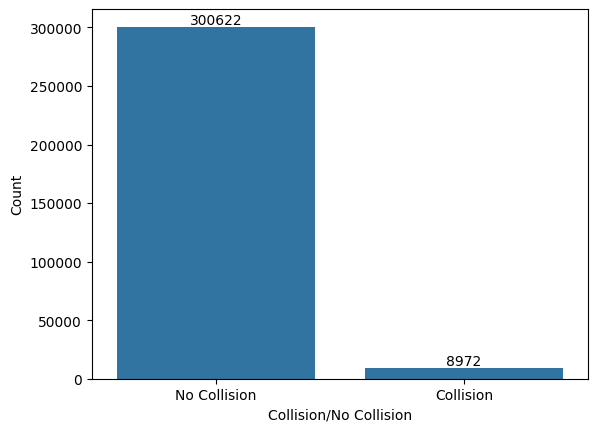

In [9]:
# plot the class balance in the targets array
ax = sns.countplot(x=target_array)
ax.bar_label(ax.containers[0])
plt.xlabel('Collision/No Collision')
plt.ylabel('Count')

plt.xticks([0,1],['No Collision','Collision'])
plt.show()

In [10]:
# attempt to calculate pos_weight based on class balance
unique,counts = np.unique(target_array,return_counts=True)
class_balance = dict(zip(unique,counts))
pos_weight_torch_value = torch.tensor([class_balance[0]/class_balance[1]])

print(int(pos_weight_torch_value))

33


### Split Data Into Training and Validation

In [12]:
# split data into train and validation sets
total_samples = len(windows)
train_size = int(train_balance * total_samples)
validation_size = total_samples - train_size

# randomly shuffle indices of in the total samples range
indices = torch.randperm(total_samples)
# train and validation indices are taken using the sizes from previous
train_indices = indices[:train_size]
validation_indices = indices[train_size:]

# split the data using the indices
train_windows = windows_array[train_indices]
train_targets = target_array[train_indices]
validation_windows = windows_array[validation_indices]
validation_targets = target_array[validation_indices]

print(f'Total Samples = {total_samples}')
print(f'Training Samples = {len(train_targets)}')
print(f'Validation Samples = {len(validation_targets)}')

Total Samples = 309594
Training Samples = 247675
Validation Samples = 61919


#### Plot Class Balance of Training and Validation Sets

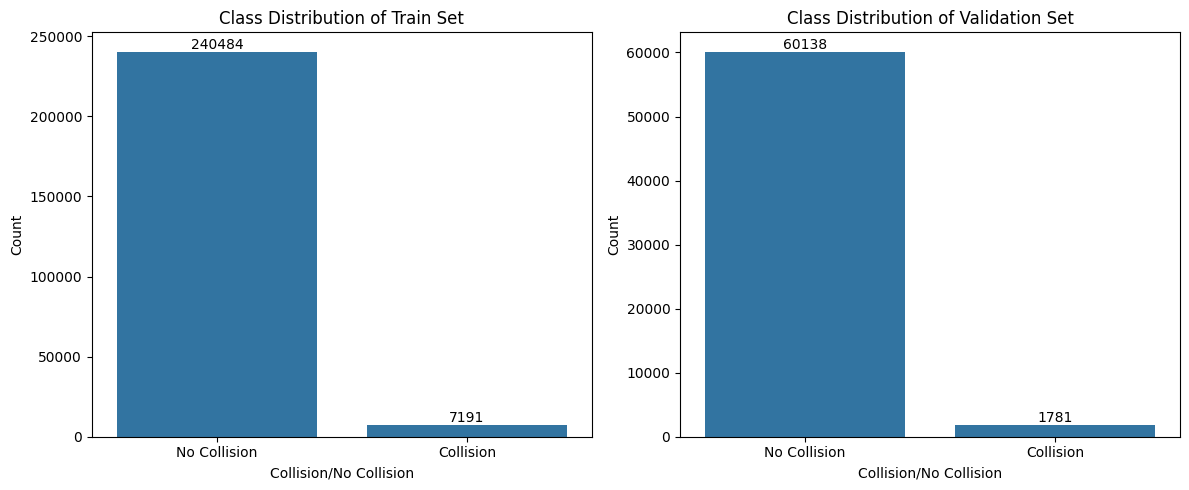

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(x=target_array[train_indices], ax=ax1)
ax1.bar_label(ax1.containers[0])
ax1.set_xlabel('Collision/No Collision')
ax1.set_ylabel('Count')
ax1.set_title('Class Distribution of Train Set')
ax1.set_xticks([0,1])
ax1.set_xticklabels(['No Collision','Collision'])

sns.countplot(x=target_array[validation_indices], ax=ax2)
ax2.bar_label(ax2.containers[0])
ax2.set_xlabel('Collision/No Collision')
ax2.set_ylabel('Count')
ax2.set_title('Class Distribution of Validation Set')
ax2.set_xticks([0,1])
ax2.set_xticklabels(['No Collision','Collision'])

plt.tight_layout()
plt.show()

### Scale Dataset Using StandardScaler

In [ ]:
# reshape to 2D array (samples,features) for scaling
train_shape = train_windows.shape
validation_shape = validation_windows.shape
train_reshaped = train_windows.reshape(-1, total_features)
validation_reshaped = validation_windows.reshape(-1, total_features)

# create and fit scaler on training data only
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_reshaped)
# transform validation data using the same scaler
validation_scaled = scaler.transform(validation_reshaped)

# reshape back to original shape (samples,window_length,features)
train_windows_scaled = train_scaled.reshape(train_shape)
validation_windows_scaled = validation_scaled.reshape(validation_shape)

# Shape of data = (samples,window_length,features)
print(train_windows_scaled.shape)
print(validation_windows_scaled.shape)

(247675, 20, 12)
(61919, 20, 12)


## Initialize Learning Model

### Convert Training and Validation Data to PyTorch Tensors and Generate DataLoaders

In [16]:
# convert to torch tensors
train_windows_tensor = torch.FloatTensor(train_windows_scaled)
train_targets_tensor = torch.FloatTensor(train_targets)
validation_windows_tensor = torch.FloatTensor(validation_windows_scaled)
validation_targets_tensor = torch.FloatTensor(validation_targets)

In [17]:
# convert data to a torch dataset
train_data = torch.utils.data.TensorDataset(train_windows_tensor, train_targets_tensor)
validation_data = torch.utils.data.TensorDataset(validation_windows_tensor, validation_targets_tensor)

train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_data,batch_size=batch_size,shuffle=False)

### Initialize Learner

In [22]:
# https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

# create the stages of the neural network (using defined hyperparameters)
# dropout is applied between layers
lstm = nn.LSTM(
    input_size=total_features,
    hidden_size=hidden_size,
    num_layers=num_layers,
    batch_first=True,
    dropout=dropout_rate
)

fc1 = nn.Linear(hidden_size,64) # first fully connected layer
relu = nn.ReLU() # rectified linear activation layer
dropout = nn.Dropout(dropout_rate) # dropout layer
fc2 = nn.Linear(64, 1) # fully connected layer

print(f'Current LSTM model definition: {lstm}')

Current LSTM model definition: LSTM(12, 128, num_layers=2, batch_first=True, dropout=0.05)


#### Move Data to GPU if Available

In [23]:
# use gpu if available, otherwise use the cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# set the device for each stage
lstm = lstm.to(device)
fc1 = fc1.to(device) # fully connected layers
fc2 = fc2.to(device)
relu = relu.to(device) # activation
dropout = dropout.to(device) # dropout

#### Define Criterion and Optimizer
pos_weight is essentially a weight appllied to the positive class. General approach is to use class balance to calculate the weight [https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html]

In [16]:
# pos_weight controls the weighting in favour of the positive class
# pos_weight = torch.tensor(32).to(device)
pos_weight = pos_weight_torch_value.to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight) # Binary Cross Entropy loss function with the pos_weight, applies sigmoid at the end when calculating loss
params = list(lstm.parameters()) + list(fc1.parameters()) + list(fc2.parameters()) # collect all trainable parameters
optimizer = torch.optim.Adam(params,lr=learning_rate) # use the adam optimizer for the model and set the learning rate, used to update the parameters

## Train and Validate the Learner Model

In [17]:
metrics_df = pd.DataFrame(columns=['Epoch','Train Loss','Validation Loss','Validation Accuracy','FPR','TPR','ROC-AUC Score'])

In [ ]:
# 0: print nothing; 1: print epoch count; 2: print epoch and confusion matrix; 3: print all metrics
debug_status = 4

# iterate for the number of epochs
for epoch in range(num_epochs):
    # set modes to training
    train_loss = 0
    lstm.train()
    fc1.train()
    fc2.train()
    
    # training loop
    for batch_windows, batch_targets in train_loader: # iterate over the batches in train_loader
        batch_windows = batch_windows.to(device)
        batch_targets = batch_targets.to(device)
    
        optimizer.zero_grad() # set gradients to zero to avoid accumulation
        lstm_out, _ = lstm(batch_windows)
        last_timestep = lstm_out[:, -1, :]
        # pass through 2 fully connected layers with ReLU activation layer and dropout
        fc1_out = fc1(last_timestep)
        relu_out = relu(fc1_out)
        dropout_out = dropout(relu_out)
        fc2_out = fc2(dropout_out)
    
        outputs = fc2_out.view(-1)
        loss = criterion(outputs, batch_targets)
    
        loss.backward() # perform backpropagation
        optimizer.step() # update weights
    
        train_loss += loss.item() # update loss
    
    # validation loop to calculate metrics using current training stage
    validation_loss = 0
    correct = 0
    total = 0
    all_logits = []    # store raw outputs (logits)
    all_probs = []     # store probabilities after sigmoid
    all_targets = []

    # set modes to validation
    lstm.eval()
    fc1.eval()
    fc2.eval()

    with torch.no_grad(): # set to not update parameters
        for batch_windows, batch_targets in validation_loader:
            batch_windows = batch_windows.to(device)
            batch_targets = batch_targets.to(device)

            lstm_out, _ = lstm(batch_windows)
            last_timestep = lstm_out[:, -1, :]
            fc1_out = fc1(last_timestep)
            relu_out = relu(fc1_out)
            fc2_out = fc2(relu_out)

            outputs = fc2_out.view(-1)  # these are logits (raw outputs before sigmoid)
            loss = criterion(outputs, batch_targets)  # BCEWithLogitsLoss applies sigmoid internally
            validation_loss += loss.item()

            # convert logits to probabilities using sigmoid
            probs = torch.sigmoid(outputs)
            # convert probabilities to binary predictions using 0.5 threshold
            predicted = (probs > 0.5).int()
            
            correct += (predicted == batch_targets.int()).sum().item()
            total += batch_targets.numel()

            # collect predictions and targets for calculating metrics
            all_logits.extend(outputs.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_targets.extend(batch_targets.cpu().numpy())

    # compute metrics using scikit learn after the forward pass through the validation stage
    # use probabilities (not logits) for ROC curve and AUC calculation
    fpr, tpr, thresholds = roc_curve(all_targets, all_probs)
    roc_auc = roc_auc_score(all_targets, all_probs)

    # get the actual FPR and TPR values from the curve
    # for metrics tracking, let's use the values closest to threshold 0.5
    optimal_idx = np.argmin(np.abs(thresholds - 0.5))
    fpr_optimal = fpr[optimal_idx]
    tpr_optimal = tpr[optimal_idx]

    # use binary predictions for classification report and confusion matrix
    binary_preds = (np.array(all_probs) > 0.5).astype(int)
    report = classification_report(all_targets, binary_preds, digits=4)
    conf_matrix = confusion_matrix(all_targets, binary_preds)

    # print epoch metrics along with additional metrics
    if debug_status >= 1: # print just the epoch count if 1
        print(f'----------------------------- Epoch [{epoch+1}/{num_epochs}] ----------------------------------------')
    if debug_status >= 3: # print all if 3
        print(f'Train Loss: {train_loss/len(train_loader)}')
        print(f'Validation Loss: {validation_loss/len(validation_loader)}')
        print(f'Validation Accuracy: {100 * correct/total}%')
        print(f'Classification Report:\n{report}')
        print(f'False Positive Rate: {fpr_optimal}')
        print(f'True Positive Rate: {tpr_optimal}')
        print(f'ROC-AUC:{roc_auc}')
    if debug_status >= 2: # print epoch and confusion matrix if 2
        print(f'Confusion Matrix:\n{conf_matrix}')

    # save all metrics to dataframe for analysis
    metrics_df.loc[len(metrics_df)] = [
        epoch,
        train_loss/len(train_loader),
        validation_loss/len(validation_loader),
        correct/total,
        fpr_optimal,
        tpr_optimal,
        roc_auc
    ]

----------------------------- Epoch [1/50] ----------------------------------------
Train Loss: 0.7951839330709642
Validation Loss: 0.7727412239371653
Validation Accuracy: 95.55225375086808%
Classification Report:
              precision    recall  f1-score   support

         0.0     0.9905    0.9635    0.9768     60138
         1.0     0.3577    0.6867    0.4704      1781

    accuracy                         0.9555     61919
   macro avg     0.6741    0.8251    0.7236     61919
weighted avg     0.9723    0.9555    0.9622     61919

False Positive Rate: 0.03719777844291463
True Positive Rate: 0.686692869174621
ROC-AUC:0.8794386424231939
Confusion Matrix:
[[57942  2196]
 [  558  1223]]
----------------------------- Epoch [2/50] ----------------------------------------
Train Loss: 0.7737319012357822
Validation Loss: 0.7494420524253401
Validation Accuracy: 83.85471341591435%
Classification Report:
              precision    recall  f1-score   support

         0.0     0.9933    0.8394  

### Display Metrics and Final Results

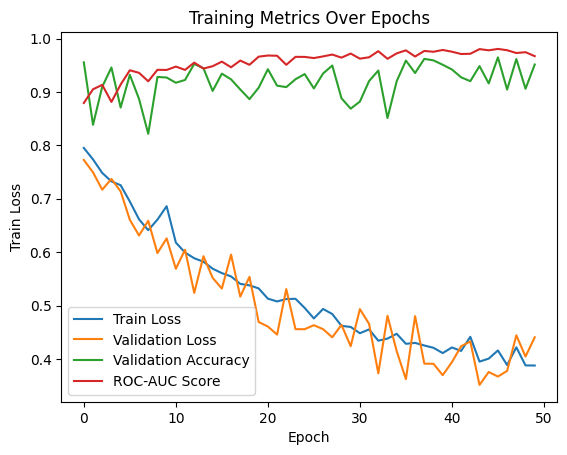

In [19]:
sns.lineplot(data=metrics_df, x='Epoch', y='Train Loss', label='Train Loss')
sns.lineplot(data=metrics_df, x='Epoch', y='Validation Loss', label='Validation Loss')
sns.lineplot(data=metrics_df, x='Epoch', y='Validation Accuracy', label='Validation Accuracy')
sns.lineplot(data=metrics_df, x='Epoch', y='ROC-AUC Score', label='ROC-AUC Score')
plt.title('Training Metrics Over Epochs')
plt.legend()
plt.show()

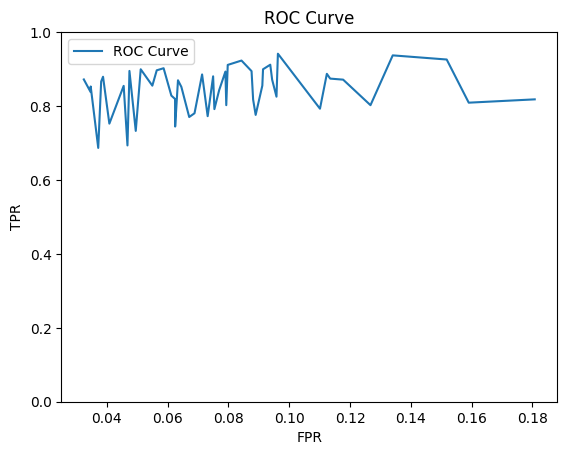

In [20]:
sns.lineplot(data=metrics_df, x='FPR', y='TPR', label='ROC Curve')
plt.title('ROC Curve')
plt.ylim(0, 1)
plt.legend()
plt.show()

In [21]:
metrics_df.head(50)

,Epoch,Train Loss,Validation Loss,Validation Accuracy,FPR,TPR,ROC-AUC Score
0,0.0,0.795184,0.772741,0.955523,0.037198,0.686693,0.879439
1,1.0,0.773732,0.749442,0.838547,0.159034,0.809096,0.905112
2,2.0,0.748421,0.717035,0.909802,0.088962,0.775969,0.913325
3,3.0,0.732511,0.737145,0.945849,0.046809,0.693431,0.881434
4,4.0,0.725428,0.713829,0.870880,0.126725,0.802358,0.913869
5,5.0,0.694892,0.660662,0.932105,0.062490,0.744526,0.940667
6,6.0,0.661463,0.631263,0.886998,0.110113,0.792813,0.935883
7,7.0,0.641148,0.658759,0.821606,0.180734,0.818080,0.920046
8,8.0,0.660955,0.598283,0.928197,0.067112,0.770354,0.941552
9,9.0,0.686085,0.625801,0.927114,0.068858,0.780460,0.941274
